# First Attempts with Keras

Let's have a play around and see what I can do. Let's just build a nice simple model, using the medium article as a follow along. 

# Necessary Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from tqdm.notebook import trange, tqdm

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
min_max = MinMaxScaler()
scaler = StandardScaler()

DOWNLOAD_DIR = Path('../download')
DOWNLOAD_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/bitcoin_price_predictor/download')

In [3]:
sns.set()

In [6]:
!pip install wandb -qqq
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: Currently logged in as: theadammurphy (use `wandb login --relogin` to force relogin)


True

In [7]:
price = pd.read_csv(DOWNLOAD_DIR / 'price.csv')
# price = pd.read_csv('price.csv')
close = price.loc[:, 'c']

In [8]:
price.head()

,timestamp,c,h,l,o
0,2010-07-17T23:00:00Z,0.04951,0.04951,0.04951,0.04951
1,2010-07-18T00:00:00Z,NaN,NaN,NaN,NaN
2,2010-07-18T01:00:00Z,NaN,NaN,NaN,NaN
3,2010-07-18T02:00:00Z,NaN,NaN,NaN,NaN
4,2010-07-18T03:00:00Z,0.05941,0.05941,0.05941,0.05941


In [9]:
price.shape

(92974, 5)

# First Attempt

In [ ]:
close.tail()

92969    47437.266848
92970    47332.765754
92971    47410.123970
92972    45889.364858
92973    47467.739097
Name: c, dtype: float64

Let's take 1 year of data and use it to predict the next 30 days. 

In [ ]:
prediction_days = 30
one_year = 365
# close[-365 - 2*30:].plot()

close_train = close[(-one_year - 2 * prediction_days) : -2 * prediction_days] # [-365 - 60 : -60]
close_val = close[-2 * prediction_days: -prediction_days] # [-60 : -30]
close_test = close[-prediction_days:] # [-30:]

<AxesSubplot:>

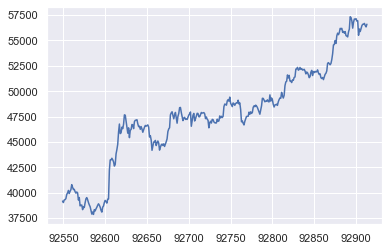

In [ ]:
close_train.plot()

<AxesSubplot:>

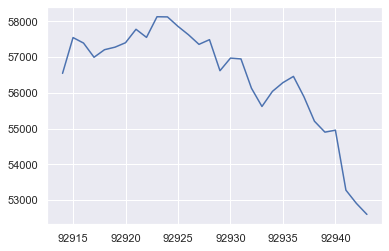

In [ ]:
close_val.plot()

<AxesSubplot:>

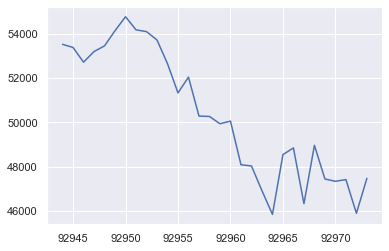

In [ ]:
close_test.plot()

In [ ]:
close_train.index[-1], close_test.index[0]

(92943, 92944)

In [ ]:
close_train.shape

(365,)

In [ ]:
def train_val_test_split(sequences, targets):
    

In [ ]:
# Prep for training
training_set = close_train.values.reshape(-1, 1)
training_set = min_max.fit_transform(training_set)
training_set = training_set.reshape((-1, 1, 1))

validation_set = close_val.values.reshape(-1, 1)
validation_set = min_max.transform(validation_set)
validation_set = validation_set.reshape((-1, 1, 1))

# Prep for testing
testing_set = close_test.values.reshape((-1, 1))
testing_set = min_max.transform(testing_set)
testing_set = testing_set.reshape((-1, 1, 1))

# We are training to predict the next day's close
# so cut off final val for X_train and start at index 1 for
# y_train
X_train = training_set[:-1]
y_train = training_set[1:]

X_val = validation_set[:-1]
y_val = validation_set[1:]

X_test = testing_set[:-1]
y_test = testing_set[1:]

In [ ]:
regressor = Sequential([
    LSTM(4),
    Dense(1)
])
regressor.compile(optimizer='adam', 
                  loss='mse',
                  metrics=[RootMeanSquaredError()])

history = regressor.fit(X_train, 
                        y_train, 
                        batch_size=5, 
                        epochs=100,
                        shuffle=False,
                        validation_data=(X_val, y_val))

Train on 364 samples, validate on 29 samples
Epoch 1/100
364/364 [==============================] - 5s 13ms/sample - loss: 0.1535 - root_mean_squared_error: 0.3917 - val_loss: 0.3875 - val_root_mean_squared_error: 0.6225
Epoch 2/100
364/364 [==============================] - 0s 930us/sample - loss: 0.0685 - root_mean_squared_error: 0.2618 - val_loss: 0.2199 - val_root_mean_squared_error: 0.4690
Epoch 3/100
364/364 [==============================] - 0s 947us/sample - loss: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.1264 - val_root_mean_squared_error: 0.3556
Epoch 4/100
364/364 [==============================] - 0s 998us/sample - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0827 - val_root_mean_squared_error: 0.2877
Epoch 5/100
364/364 [==============================] - 0s 1ms/sample - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2513
Epoch 6/100
364/364 [==============================] - 0s 977us/sample - 

364/364 [==============================] - 0s 927us/sample - loss: 4.6616e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1631e-04 - val_root_mean_squared_error: 0.0286
Epoch 91/100
364/364 [==============================] - 0s 883us/sample - loss: 4.6636e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1715e-04 - val_root_mean_squared_error: 0.0286
Epoch 92/100
364/364 [==============================] - 0s 889us/sample - loss: 4.6656e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1797e-04 - val_root_mean_squared_error: 0.0286
Epoch 93/100
364/364 [==============================] - 0s 872us/sample - loss: 4.6676e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1876e-04 - val_root_mean_squared_error: 0.0286
Epoch 94/100
364/364 [==============================] - 0s 831us/sample - loss: 4.6694e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1953e-04 - val_root_mean_squared_error: 0.0286
Epoch 95/100
364/364 [==============================] - 0s 846us/sample - loss: 4.6

In [ ]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

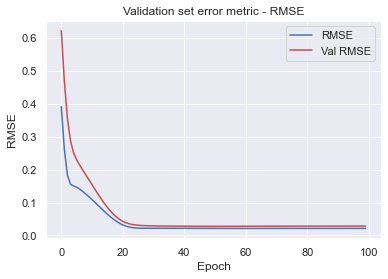

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

fig, ax = plt.subplots()
plt.plot(rmse, 'b', label='RMSE')
plt.plot(val_rmse, 'r', label='Val RMSE')
ax.set(xlabel='Epoch', ylabel='RMSE',
      title='Validation set error metric - RMSE')
# plt.yticks([0, .1, .2, .3, .4])
plt.legend()
plt.show()

In [ ]:
# Smallest rmse
min(val_rmse), np.argmin(val_rmse)

(0.02795342, 50)

In [ ]:
val_rmse[-1]

0.028698

~3% of max change in dataset. We think this is not very good. A 3% price change is significant. Hard to interpret. 

In [ ]:
# Smallest loss
min(val_loss), np.argmin(val_loss)

(0.0007813936611236041, 50)

In [ ]:
history.history['val_root_mean_squared_error'][-1]

0.028698

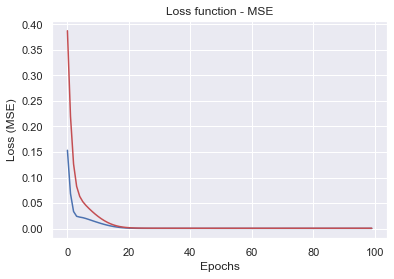

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots()
plt.plot(loss, 'b', label='Loss (MSE)')
plt.plot(val_loss, 'r', label='Val Loss (MSE)')
ax.set(xlabel='Epochs', ylabel='Loss (MSE)',
      title='Loss function - MSE')
plt.show()

In [ ]:
predicted_price = regressor.predict(X_test)
predicted_price = min_max.inverse_transform(predicted_price)

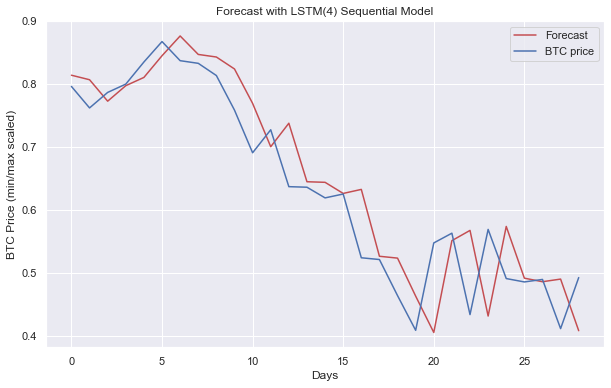

In [ ]:
# Need to inverse transform to get correct y-axis values
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(regressor.predict(X_test), 'r', label='Forecast')
plt.plot(np.ravel(y_test), 'b', label='BTC price')
plt.legend()
ax.set(xlabel='Days', ylabel='BTC Price (min/max scaled)',
      title='Forecast with LSTM(4) Sequential Model')
plt.show()

This is expected (from a model doing a very bad job). Trained on bull data and validated on bear data. 

In [ ]:
# Loss for this model
rmse_class = RootMeanSquaredError()
rmse_class(y_test, regressor.predict(X_test)).numpy()

0.06531364

In [ ]:
# WHY IS THIS DIFFERENT TO THE VALIDATION_RMSE????
rmse_class(y_val, regressor.predict(X_val)).numpy()

0.05044525

In [ ]:
rmse_class(y_train, regressor.predict(X_train)).numpy()

0.027286403

# LSTMs

## Info

Couple of helpful ML Mastery articles:
- [How to Reshape Input Data for LSTMs - Keras](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)
- [How to Prepare Univariate Time Series Data for LSTMs](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/)

Univariate is when we just have a time column and a column that we are trying to predict.

There are many ways to split up our time series data and exploring these would definititely be fruitful and beneficial for the problem e.g. maybe we need overlapping sequences, perhaps non-overlapping is better but the model needs to maintain state across the sub-sequences and so on.

Input to LSTMs in Keras must be `[samples, timesteps, features]`. Note that `timesteps` is a vital tuning parameter, so just picking 1 week's worth of data is not going to cut it. Jason says that 200-400 timesteps is usually optimal though.

[Choosing the timestamp split](https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/) will be an important hyperparameter. Totally possible to have disjoint sequences. 

What does it mean to keep the internal state preserved or not? What happens if we do/n't do this?

## Attempt Two

In [ ]:
def make_seqs_and_targets(data, seq_length):
    """
    Return a tuple of (seq, target) pairs.
    The target is the next element in the series.
    
    We assume this is a univariate timeseries problem and thus data should only
    contain one feature.
    
    seqs output shape: [num_samples, seq_length, 1] (as required by Keras)
    num_samples is calculated below and varies based on seq_length and len(series)
    """
    if len(data.shape) > 2 and data.shape[1] > 1:
        raise TypeError('Data must be univariate')
    if not isinstance(data, np.ndarray):
        data = data.values

    seqs = []
    targets = []
    i = 0
    while i + seq_length < len(data):
        seq = data[i : i + seq_length]
        target = data[i + seq_length]
        seqs.append(seq)
        targets.append(target)
        i += 1

    seqs = np.array(seqs)
    targets = np.array(targets)
    
    seqs = seqs.reshape(-1, seq_length, 1) # Univariate timeseries data
    return seqs, targets

In [ ]:
# Found by inspection
price_nonans = price.iloc[76307:]

In [ ]:
len(price_nonans)

16667

In [ ]:
seqs, targets = make_seqs_and_targets(price_nonans.c, 168)

In [ ]:
targets.shape

(16499,)

In [ ]:
num_samples = seqs.shape[0]
num_train_samples = int(num_samples * 0.6)
num_val_samples = int(num_samples * 0.2) + 1
num_test_samples = int(num_samples * 0.2) + 1

In [ ]:
num_train_samples + num_val_samples + num_test_samples == num_samples

True

In [ ]:
X_train, y_train = seqs[:num_train_samples], targets[:num_train_samples]
X_val, y_val = seqs[num_train_samples:num_train_samples + num_val_samples], \
               targets[num_train_samples:num_train_samples + num_val_samples]
X_test, y_test = seqs[-num_test_samples:], targets[-num_test_samples:]

In [ ]:
len(X_val)

3300

In [ ]:
len(X_train) / 400

24.7475

# RUN THIS AGAIN BUT UPLOAD IT TO WANDB!!!

In [ ]:
# Initalize wandb with project name
run = wandb.init(project='bitcoin_price_predictor',
                 config={ # and include hyperparameters and metadata
                    'batch_size': 400,
                    'epochs': 200,
                    'loss_function': 'mse',
                    'shuffle': False,
                    'optimizer': 'adam',
                    'metrics': None
                 })
config = wandb.config # we use this to configure our experiment

# Init model like usual
model = Sequential([
    LSTM(32, input_shape=(168, 1)),
    Dense(1)
])
model.summary()

# Compile model like usual (but use config. for all params)
# is this really necessary? What happens if I don't use config.???
model.compile(optimizer=config.optimizer,
             loss=config.loss_function,
             metrics=[config.metrics])

epoch,49
loss,74897416.0
val_loss,106733296.0
_runtime,58
_timestamp,1615213177
_step,49
best_val_loss,106733296.0
best_epoch,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit as normal - use config. for everything and add WandbCallback
history = model.fit(X_train, 
                    y_train, 
                    batch_size=config.batch_size, 
                    epochs=config.epochs,
                    shuffle=config.shuffle,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback()])

Epoch 1/200
25/25 [==============================] - 3s 37ms/step - loss: 71483143.7692 - val_loss: 106991992.0000
Epoch 2/200
25/25 [==============================] - 0s 15ms/step - loss: 71480212.3846 - val_loss: 106988296.0000
Epoch 3/200
25/25 [==============================] - 0s 15ms/step - loss: 71477288.2308 - val_loss: 106984608.0000
Epoch 4/200
25/25 [==============================] - 0s 15ms/step - loss: 71474363.2308 - val_loss: 106980936.0000
Epoch 5/200
25/25 [==============================] - 0s 15ms/step - loss: 71471430.8462 - val_loss: 106977256.0000
Epoch 6/200
25/25 [==============================] - 0s 15ms/step - loss: 71468501.0000 - val_loss: 106973568.0000
Epoch 7/200
25/25 [==============================] - 0s 15ms/step - loss: 71465570.5385 - val_loss: 106969904.0000
Epoch 8/200
25/25 [==============================] - 0s 15ms/step - loss: 71462629.8462 - val_loss: 106966208.0000
Epoch 9/200
25/25 [==============================] - 0s 15ms/step - loss: 714597

Doesn't look like having unnormalized data is very helpful.

## LSTM with Normalized Data

We need to split the data first (train, val, test) and then scale before we turn it into the sequences we want to feed into the LSTM.

When we call `int()` it always rounds down. Perhaps `math.floor()` would be better or even fucking floor division!

We only need to define two of the three sizes. Since they sum to one. So we just need the sizes for train and val and then test will be 1-that. 

Wait... I need to put in the targets too but the targets exist from the features. 

So I need to scale all the data using the train/val/test sizes I've specified. 

Jason says I need to [reframe my time-series problem as a supervised ML problem](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/). 

Think it makes sense to first transform the problem into a supervised ML task. 

Can defo make use of the `series_to_supervised` function in the above article to elegantly reframe the dataset before moving on. This may make it possible to just `fit_transform()` the whole dataset and then

In [ ]:
def train_val_test_split(data, train_size=0.6, val_size=0.2):
    """
    data should be a dataframe, series or numpy object in its original (probably
    tabular) form. It should _not_ be in a form ready to be fed into an LSTM,
    we will do that transformation after this. 

    We need to split the data first if we are to transform it before feeding it
    into our LSTM.
    """
    assert train_size + val_size < 1

    num_samples = len(data)
    # int() rounds all numbers down
    num_train_samples = int(num_samples * train_size)
    num_val_samples = int(num_samples * val_size)

    # Slice dataset into train-val-test
    X_train = data[:num_train_samples]
    X_val = data[num_train_samples:num_train_samples + num_val_samples]
    X_test = data[num_train_samples + num_val_samples:]

    # Turn into 2D arraus
    X_train = X_train.values.reshape(-1, 1)
    X_val = X_val.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)

    return X_train, X_val, X_test

In [ ]:
X_train, X_val, X_test = train_val_test_split(price_nonans.c)

In [ ]:
len(X_train) + len(X_val) + len(X_test) == len(price_nonans.c)

True

In [ ]:
X_train.shape

(10000, 1)

In [ ]:
min_max = MinMaxScaler()

X_train_scaled = min_max.fit_transform(X_train)
X_val_scaled = min_max.transform(X_val)
X_test_scaled = min_max.transform(X_test)

In [ ]:
type(X_train_scaled)
isinstance(X_train_scaled, np.ndarray)

True

In [ ]:
X_train, y_train = make_seqs_and_targets(X_train_scaled, 168)
X_val, y_val = make_seqs_and_targets(X_val_scaled, 168)
X_test, y_test = make_seqs_and_targets(X_test_scaled, 168)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(9832, 168, 1) (9832, 1)
(3165, 168, 1) (3165, 1)
(3166, 168, 1) (3166, 1)


# NaN Investigation

Tldr: drop them, only 55 NaNs in total after 2011 across 7 days.

In [ ]:
price = pd.read_csv(DOWNLOAD_DIR / 'price.csv', parse_dates=[0])
price = price.set_index('timestamp')
# price = pd.read_csv('price.csv')
close = price.loc[:, 'c']

In [ ]:
price[close.isna()].to_csv('Nans.csv')

In [ ]:
price.head()

,c,h,l,o
timestamp,,,,
2010-07-17 23:00:00+00:00,0.04951,0.04951,0.04951,0.04951
2010-07-18 00:00:00+00:00,NaN,NaN,NaN,NaN
2010-07-18 01:00:00+00:00,NaN,NaN,NaN,NaN
2010-07-18 02:00:00+00:00,NaN,NaN,NaN,NaN
2010-07-18 03:00:00+00:00,0.05941,0.05941,0.05941,0.05941


In [ ]:
price.c.isna()

DatetimeIndex(['2010-07-17 23:00:00+00:00', '2010-07-18 00:00:00+00:00',
               '2010-07-18 01:00:00+00:00', '2010-07-18 02:00:00+00:00',
               '2010-07-18 03:00:00+00:00', '2010-07-18 04:00:00+00:00',
               '2010-07-18 05:00:00+00:00', '2010-07-18 06:00:00+00:00',
               '2010-07-18 07:00:00+00:00', '2010-07-18 08:00:00+00:00',
               ...
               '2021-02-23 11:00:00+00:00', '2021-02-23 12:00:00+00:00',
               '2021-02-23 13:00:00+00:00', '2021-02-23 14:00:00+00:00',
               '2021-02-23 15:00:00+00:00', '2021-02-23 16:00:00+00:00',
               '2021-02-23 17:00:00+00:00', '2021-02-23 18:00:00+00:00',
               '2021-02-23 19:00:00+00:00', '2021-02-23 20:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=92974, freq=None)

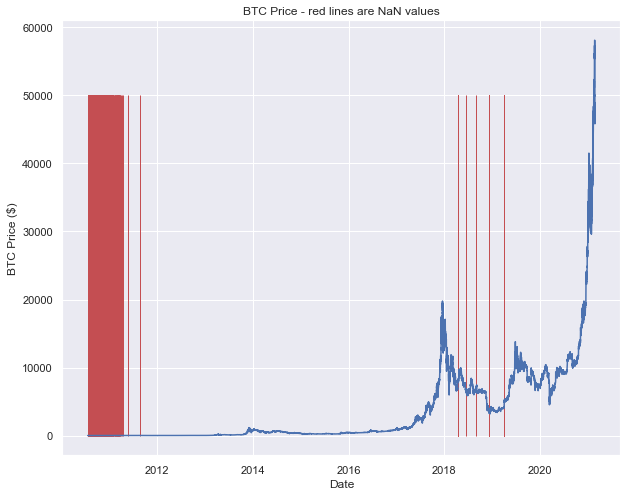

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
c_nans = price.c[price.c.isna()]
c_no_nans = price.c[price.c.notna()]
# plt.scatter(c_no_nans.index, c_no_nans.values, s=1)
plt.plot(c_no_nans)
plt.vlines(c_nans.index, ymin=0, ymax=50000, colors='r', linewidths=1)
ax.set(xlabel='Date', ylabel='BTC Price ($)', 
       title='BTC Price - red lines are NaN values')
plt.show()

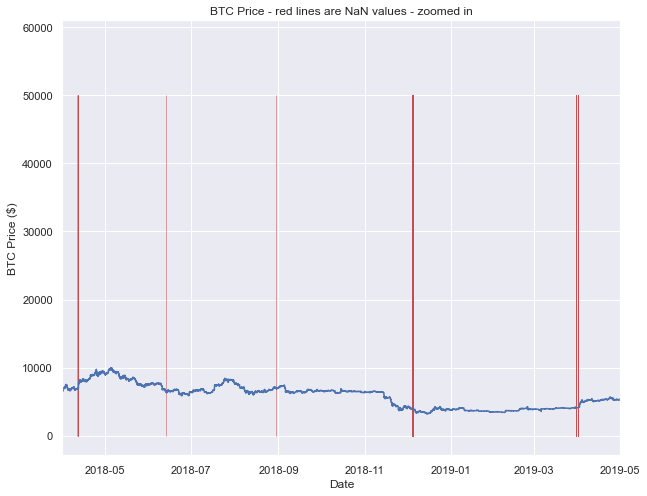

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
c_nans = price.c[price.c.isna()]
c_no_nans = price.c[price.c.notna()]
# plt.scatter(c_no_nans.index, c_no_nans.values, s=1)
plt.plot(c_no_nans)
plt.vlines(c_nans.index, ymin=0, ymax=50000, colors='r', linewidths=0.5)
plt.xlim((np.datetime64('2018-04'), np.datetime64('2019-05')))
ax.set(xlabel='Date', ylabel='BTC Price ($)', 
       title='BTC Price - red lines are NaN values - zoomed in')
plt.show()

In [ ]:
# Only 55 hours missing after 2011 (all in 2018 and 2019)
len(c_nans.loc['2012':])

55

In [ ]:
# Only across 7 days
len(np.unique(c_nans.loc['2012':].index.date))

7

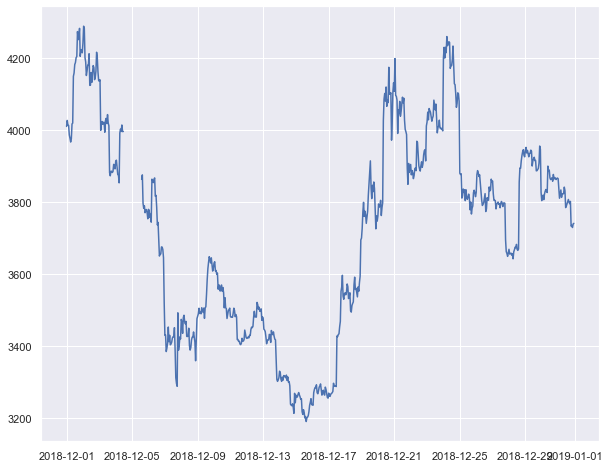

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(price.c.loc['2018-12'])

In [ ]:
c_nans_removed = price.c.dropna()

# ML Mastery Follow Along

Walkthrough of [this](https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/) article

In [ ]:
c_nans_removed.shape

(92192,)

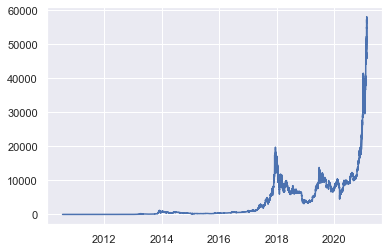

In [ ]:
plt.plot(c_nans_removed)
plt.show()

## Creating a baseline model

We won't do this here for brevity.

### Train-Test Split

In [ ]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [ ]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] \
            for i in range(interval, len(data))]

### Series as Supervised Learning

Need to frame as supervised ML problem

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [ ]:
series_to_supervised(price.c, n_in=168).shape

(85187, 169)

### Walk-Forward Validation

Forcast for each observation in the test dataset one at a time. After each forecast is made for a time step in the test dataset, the true observation for the forecast is added to the test dataset and made available to the model. 

You can refit simpler models but more complex ones e.g. NNs are not refit given the computational cost. Something to toy with here. But we can still use the new input to make a prediction which is something at least. 

Generic func to fit the model once on the train dataset and for a specific model config. Takes train, model config and returns the fit model ready to make predictions.

In [ ]:
# fit a model
def model_fit(train, config):
    return None

As each time step of the dataset is enumerated, we make a prediction with the fit model. 

The func `model_predict()` takes the fit model, the history, and the model config and makes a single one-step prediction.

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    return 0.0

We add this pred to the list of preds and true observation is added to the list of observations. Both lists grow on each step in the walk-forward validation.

Then we compare all the preds to the true values in the test set and calc and error measure.

In [ ]:
# root mean squared error, or rmse
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

Complete walk-forward validation function.

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, config):
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, config)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test dataset
    for i in range(len(test)):
        # use fitted model to make forecast
        yhat = model_predict(model, history, config)
        # store forecaxst in the list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

### Repeat Evaluation

Given the stochastic nature of NNs, we want to repeat our evaluations multiple times.

In [ ]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate model n times
    scores = [walk_forward_validation(data, n_test, config) \
              for _ in range(n_repeats)]
    return scores

### Summarize Performance

In [ ]:
# Summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, scores_std = np.mean(scores), np.std(scores)
    print(f'{name}: {scores_m:.3f} RMSE (+/- {scores_std:.3f})')
    sns.boxplot(x=scores)
    plt.show()

## Baseline Model - Persistence (average of last week)

In [ ]:
# Nothing to fit
def model_fit(train, config):
    return None

def model_predict(model, history, config):
    values = []
    for offset in config:
        values.append(history[-offset])
    return np.mean(values)

 > 946.621
 > 946.621
 > 946.621
 > 946.621
 > 946.621
persistence: 946.621 RMSE (+/- 0.000)


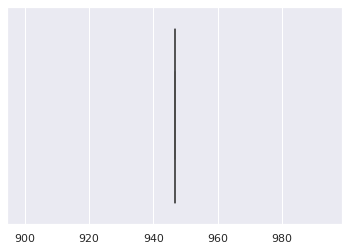

In [ ]:
price = pd.read_csv(DOWNLOAD_DIR / 'price.csv', parse_dates=[0])
price = price.set_index('timestamp')
close = price.loc[:, 'c'].dropna()
data = close.values
# data split
n_test = int(len(data) * 0.33)
# define config
config = np.arange(1, 169)
# grid search
scores = repeat_evaluate(data, config, n_test, 5)
summarize_scores('persistence', scores)

## MLP

Currently, we are using an autoregressive approach. In other words, we are assuming that the next time step was taken as a function of some number of past (or lag) observations.

This is a common approach for classical statistical time series forecasting.

Note that it makes a lot of sense to evaluate an MLP first as well. We want to know that our LSTM is definitely better.

The function `series_to_supervised()` does exactly what we want. It frames the problem perfectly for an MLP.

The model has input layer with some number of prior observations, we specify with `input_dim`. 

Note that the number of lag observations (`n_input`), the number of nodes in our (for the moment) single layer (`n_nodes`), the number of training epochs (`n_epochs`) and batch size (`n_batch`) are all hyperparameters that will need tuning. 

Remember that, for walk-forward validation, we are only making one prediction at a time and so will not use the bulk prediction features of Keras. 

Thus the input to `model.predict()` must be of shape `(1, n_input)` as `n_input` is the number of lag observations we will include.

_runtime,3127
_timestamp,1615902866
_step,11


_runtime,▁▁▃▃▃▃▃▅▇▇██
_timestamp,▁▁▃▃▃▃▃▅▇▇██
_step,▁▂▂▃▄▄▅▅▆▇▇█


Repeat #0



 > 844.524


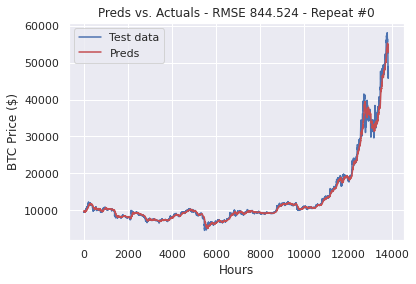

Repeat #1



 > 12195.533


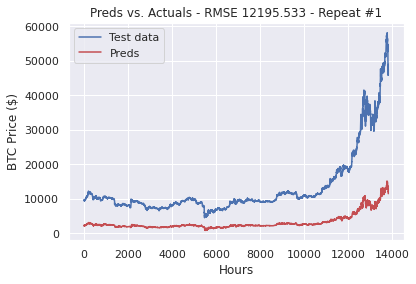

Repeat #2



 > 965.476


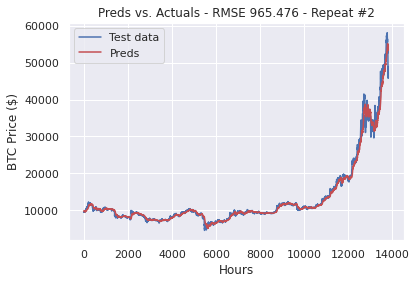

Repeat #3



 > 1127.272


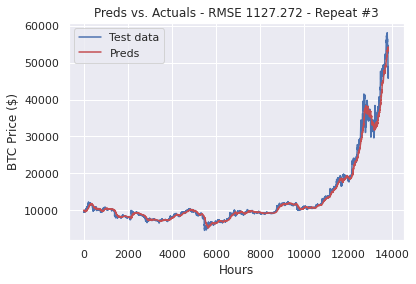

Repeat #4



 > 4654.320


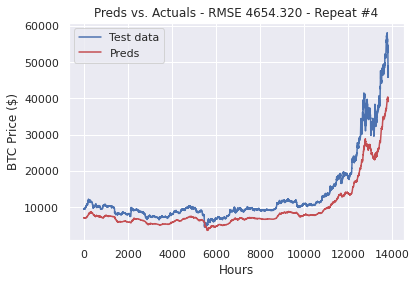

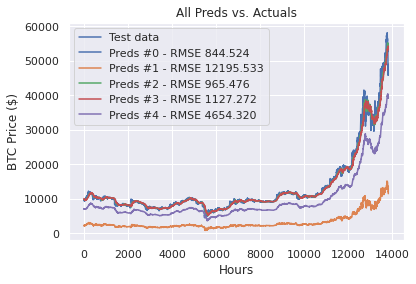

mlp: 3957.425 RMSE (+/- 4358.985)


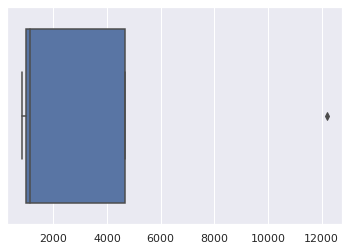

In [51]:
# Initalize wandb with project name
run = wandb.init(project='bitcoin_price_predictor',
                 config={
                     'test_size': 0.15,
                     'n_input': 168, # num lag observations
                     'n_nodes': 300, # num nodes per lauyer
                     'n_epochs': 100, # num training epochs
                     'n_batch': 168 * 20, # batch size
                     'n_repeats': 5, # num repeats of WF validation
                     'activation': 'relu',
                     'loss': 'mse',
                     'optimizer': 'adam',
                     'val_split': 0.15
                         })
config = wandb.config # we use this to configure our experiment

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]


def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error, or rmse
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))


def model_fit(train, config):
    # unpack config
    # n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    train_data = series_to_supervised(train, n_in=config.n_input)
    X_train, y_train = train_data[:, :-1], train_data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(config.n_nodes, activation=config.activation, 
                    input_dim=config.n_input))
    model.add(Dense(1))
    model.compile(loss=config.loss, optimizer=config.optimizer)
    # fit
    model.fit(X_train, y_train, epochs=config.n_epochs,
              batch_size=config.n_batch, verbose=0,
              shuffle=False, validation_split=config.val_split)
            #   callbacks=[WandbCallback()])
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    # n_input, _, _, _ = config
    # prepare data
    x_input = np.array(history[-config.n_input:]).reshape(1, config.n_input)
    # forecast, one at a time
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, config):
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, config)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test dataset
    for i in trange(len(test)):
        # use fitted model to make forecast
        yhat = model_predict(model, history, config)
        # store forecaxst in the list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error, predictions, test

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30, plot=True):
    scores = []
    predictions = []
    for i in range(n_repeats):
        print(f'Repeat #{i}')
        score, pred, test = walk_forward_validation(data, n_test, config)
        scores.append(score)
        predictions.append(pred)
        if plot:
            fig, ax = plt.subplots()
            ax.plot(test, 'b', label='Test data')
            ax.plot(pred, 'r', label='Preds')
            ax.legend()
            ax.set(xlabel='Hours', ylabel='BTC Price ($)',
                title=f'Preds vs. Actuals - RMSE {score:.3f} - Repeat #{i}')
            wandb.log({f'Preds vs Actuals #{i}': wandb.Image(fig)})
            plt.show()
    if plot:
        fig, ax = plt.subplots()
        ax.plot(test, 'b', label='Test data')
        for i, prediction in enumerate(predictions):
            ax.plot(prediction, label=f'Preds #{i} - RMSE {scores[i]:.3f}')
        ax.legend()
        ax.set(xlabel='Hours', ylabel='BTC Price ($)',
               title='All Preds vs. Actuals')
        wandb.log({f'All preds vs. actuals': wandb.Image(fig)})
        plt.show()
    return scores

# Summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, scores_std = np.mean(scores), np.std(scores)
    print(f'{name}: {scores_m:.3f} RMSE (+/- {scores_std:.3f})')
    boxplot = sns.boxplot(x=scores)
    wandb.log({'RMSE Walk-Forward Validation Scores Distribution': wandb.Image(boxplot)})
    plt.show()

price = pd.read_csv(DOWNLOAD_DIR / 'price.csv', parse_dates=[0])
price = price.set_index('timestamp')
close = price.loc[:, 'c'].dropna()
data = close.values
# # data split
n_test = int(len(data) * config.test_size)
# # num_lag_observations, num_nodes_in_layer, num_training_epochs, batch_size
# config = [168, 300, 50, 168 * 20]
# # grid search
scores = repeat_evaluate(data, config, n_test, n_repeats=config.n_repeats)
wandb.log({'Repeated walk-forward validation scores': scores})
summarize_scores('mlp', scores)

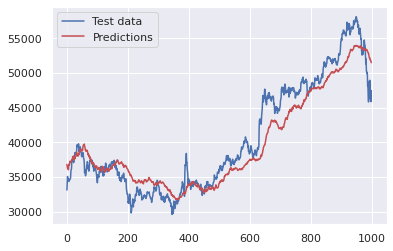

 > 2489.816


In [28]:
error, preds, test = walk_forward_validation(data, 1000, wandb.config)

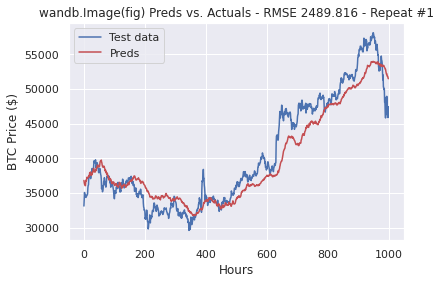

In [50]:
# This works!!!
fig, ax = plt.subplots()
ax.plot(test, 'b', label='Test data')
ax.plot(preds, 'r', label='Preds')
ax.legend()
ax.set(xlabel='Hours', ylabel='BTC Price ($)',
       title=f'wandb.Image(fig) Preds vs. Actuals - RMSE {error:.3f} - Repeat #1')
wandb.log({'test': wandb.Image(fig)})
plt.show()

In [44]:
float(preds[0])

36815.51953125

In [48]:
i = 0
preds = [float(p) for p in preds]
xs = np.arange(len(test))
d = [[x, t, p] for (x, t, p) in zip(xs, test, preds)]
table = wandb.Table(data=d, columns=['x', 'test', 'preds'])
wandb.log({f'Preds vs Actuals - Repeat #{i}': wandb.plot.line(
    table, 'x', ['test', 'preds'],
    # xs=xs,
    # ys=ys,
    # keys=['Test data', 'Preds'],
    title=f'Preds vs. Actuals - RMSE {error:.3f} - Repeat #{i}'
)})

Great! So this has an average loss of $452 (without any scaling or anything). Amazing.

## LSTM

Plenty of variation for us to try here.

- LSTM 
- CNN-LSTM - CNN learns input features, LSTM interprets them
- ConvLSTM - LSTM units read input data using the convolutional process of a CNN.

LSTMs read each time step one at a time _but_ it remembers the internal state as it reads across time steps.

LSTMs usually preform better if the data is stationary. So, we perform difference opeations to remove trends and seasonal structures. Obvs we should check if it actually makes a difference. Need to test this.

For [Jason's example](https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/) he subtracts the value from one year ago for each observation.

In [ ]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]


def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error, or rmse
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))


# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] \
            for i in range(interval, len(data))]


def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((-1, n_input, 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='tanh', stateful=False,
                   input_shape=(n_input, 1)))
                #    batch_input_shape=(n_batch, n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=optimizer)
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, 
              batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = np.array(history[-n_input:]).reshape(1, n_input, 1)
    # forecast, one at a time
    yhat = model.predict(x_input, verbose=0)
    return yhat[0] + correction

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, config):
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, config)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test dataset
    for i in trange(len(test)):
        # use fitted model to make forecast
        yhat = model_predict(model, history, config)
        # store forecaxst in the list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    scores = []
    for i in range(n_repeats):
        print(f'Repeat #{i}')
        score = walk_forward_validation(data, n_test, config)
        scores.append(score)
    return scores

# Summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, scores_std = np.mean(scores), np.std(scores)
    print(f'{name}: {scores_m:.3f} RMSE (+/- {scores_std:.3f})')
    sns.boxplot(x=scores)
    plt.show()

price = pd.read_csv(DOWNLOAD_DIR / 'price.csv', parse_dates=[0])
price = price.set_index('timestamp')
close = price.loc[:, 'c'].dropna()
data = close.values
# data split ~8k observations
n_test = int(len(data) * 0.10)
# num_lag_observations, num_nodes_in_layer, num_training_epochs, batch_size, stationary_interval
config = [168, 200, 300, 168 * 50, 0]
# grid search
scores = repeat_evaluate(data, config, n_test, n_repeats=30)
summarize_scores('lstm', scores)

Repeat #0



 > 10965.856
Repeat #1


### series_to_supervised with scaling

In [ ]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]


def series_to_supervised(data, n_in=1, n_out=1, n_test=None):
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values